In [2]:
from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
import tensorflow as tf
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import os
from sklearn import preprocessing

In [3]:
# Preprocessing Data

dir_path ='data'
X_test = np.load(os.path.join(dir_path,"X_test.npy"))
X_test = np.expand_dims(X_test,axis=-1)
y_test = np.load(os.path.join(dir_path,"y_test.npy"))
y_test -= np.amin(y_test)
person_train_valid = np.load(os.path.join(dir_path,"person_train_valid.npy"))
X_train_valid = np.load(os.path.join(dir_path,"X_train_valid.npy"))
X_train_valid = np.expand_dims(X_train_valid,axis=-1)

y_train_valid = np.load(os.path.join(dir_path,"y_train_valid.npy"))
y_train_valid -= np.amin(y_train_valid)

person_test = np.load(os.path.join(dir_path,"person_test.npy"))

#normalize data
N_trials,N_eeg,N_bins,_ = X_train_valid.shape
X_train_valid_norm = np.reshape(preprocessing.scale(np.reshape(X_train_valid,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))
N_trials,N_eeg,N_bins,_ = X_test.shape
X_test_norm = np.reshape(preprocessing.scale(np.reshape(X_test,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))

# print data
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
# Scaling data across each channel to prevent exploding weight issue
for i in range(22):
    scaler = StandardScaler()
    scaler.fit(X_train_valid[:,i,:,0])
    X_train_valid[:,i,:,0] = scaler.transform(X_train_valid[:,i,:,0])
    X_test[:,i,:,0] = scaler.transform(X_test[:,i,:,0])

In [5]:
# Sampling 

def sampling(args):   #args (tensor): mean and log of variance of Q(z|X)
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  # Returns ampled latent vector


In [6]:
# Parameters

input_shape = X_train_valid.shape[1:]
batch_size = 128
kernel_size = 7
filters = 16
latent_dim = 2
epochs = 500

In [7]:
# VAE

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
filters *= 2

# ENCODER
x = Conv2D(filters=filters,kernel_size=(1, 50),strides=(1,25))(x)
x = LeakyReLU(alpha=0.3)(x)
filters *= 2
x = Conv2D(filters=filters,kernel_size=(22, 1))(x)
x = LeakyReLU(alpha=0.3)(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8 
print("zlog ", z_log_var)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) #sample output as input

# Compile encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# DECODER
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters=filters,kernel_size=(22, 1),activation='relu')(x)
filters //= 2
x = Conv2DTranspose(filters=filters,kernel_size=(1, 50),activation='relu',strides=(1,25))(x)
filters //= 2
outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,padding='same',name='decoder_output')(x)

# Compile decoder
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# Compile complete model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

zlog  KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='tf.__operators__.add/AddV2:0', description="created by layer 'tf.__operators__.add'")
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 22, 1000, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 39, 32)   1632        encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 22, 39, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Con

In [7]:

models = (encoder, decoder)
data = (X_test, y_test)

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = Adam(learning_rate=0.001, beta_1=0.1, beta_2=0.999, amsgrad=False)

vae.compile(optimizer=optimizer, loss=None)

model_results = vae.fit(x = X_train_valid,epochs=epochs,batch_size=batch_size,validation_data=(X_test, None))


Epoch 1/500
17/17 [==============================] - 18s 482ms/step - loss: 21977.1621 - val_loss: 23686.5938
Epoch 2/500
17/17 [==============================] - 2s 97ms/step - loss: 22008.9941 - val_loss: 23687.7109
Epoch 3/500
17/17 [==============================] - 2s 97ms/step - loss: 22054.2871 - val_loss: 23682.7246
Epoch 4/500
17/17 [==============================] - 2s 101ms/step - loss: 21984.2090 - val_loss: 23583.5312
Epoch 5/500
17/17 [==============================] - 2s 108ms/step - loss: 21746.7031 - val_loss: 23239.1094
Epoch 6/500
17/17 [==============================] - 2s 100ms/step - loss: 21530.9219 - val_loss: 23116.8945
Epoch 7/500
17/17 [==============================] - 2s 98ms/step - loss: 21438.3965 - val_loss: 23081.5039
Epoch 8/500
17/17 [==============================] - 2s 101ms/step - loss: 21402.7891 - val_loss: 23126.0547
Epoch 9/500
17/17 [==============================] - 2s 99ms/step - loss: 21307.0703 - val_loss: 23094.2324
Epoch 10/500
17/17 [==

In [14]:
# Logistic regression for classification

mlx_test,_,_ = encoder.predict(X_test,batch_size=128)
mly_test = y_test
mlx_train,_,_ = encoder.predict(X_train_valid,batch_size=128)
mly_train = y_train_valid 

In [15]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(mlx_train, mly_train)
y_pred = lm.predict(mlx_test)
print('Test accuracy:',np.sum(y_pred==mly_test)/mly_test.shape[0])

Test accuracy: 0.5572373522458629


In [17]:
reconstructed_test= vae.predict(X_test)

In [18]:
reconstructed_test.shape

(2115, 22, 1000, 1)

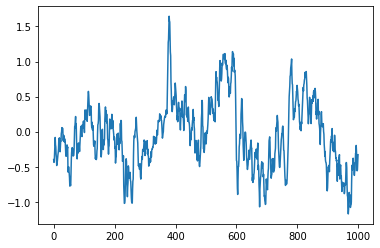

In [19]:
plt.plot(range(1000),reconstructed_test[0,0,:,0])

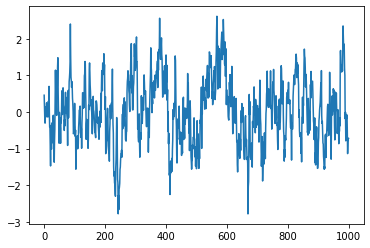

In [20]:
plt.plot(range(1000),X_test[0,0,:,0])